<a href="https://colab.research.google.com/github/proflynch/Tekbac/blob/master/LSTM_TS_Forecast_US_EUR_Exchange_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Using LSTM to predict future time series of the US Dollar and Euro exchange rates.
# Importing the relevant libraries and API.
import pandas as pd
pd.options.display.max_colwidth = 60
!pip install fredapi

import tensorflow as tf
from tensorflow import keras
import numpy as np
from numpy import mean
from fredapi import Fred              # Import the FRED API
import numpy as np
import math
import statistics
import pylab


%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(20, 5)


In [8]:
fred = Fred(api_key='419401c4103800a51c50e6113b1f7500')
# Retrieve historical data for the US/EUR exchange rate series between Sept 2017 and Sept 2019.
data = fred.get_series('DEXUSEU',observation_start='2017-09-01', observation_end='2019-09-01',name='Price')
# We use data.tail() to view the first 5 values from the dataset
data.head()

2017-09-01    1.1878
2017-09-04       NaN
2017-09-05    1.1911
2017-09-06    1.1943
2017-09-07    1.2028
dtype: float64

In [9]:
#Converting the data series into a dataframe (so we can replace missing values easily).
Input= data.to_frame()
Input

,0
2017-09-01,1.1878
2017-09-04,NaN
2017-09-05,1.1911
2017-09-06,1.1943
2017-09-07,1.2028
...,...
2019-08-26,1.1112
2019-08-27,1.1094
2019-08-28,1.1084
2019-08-29,1.1059


Text(0, 0.5, 'Price')

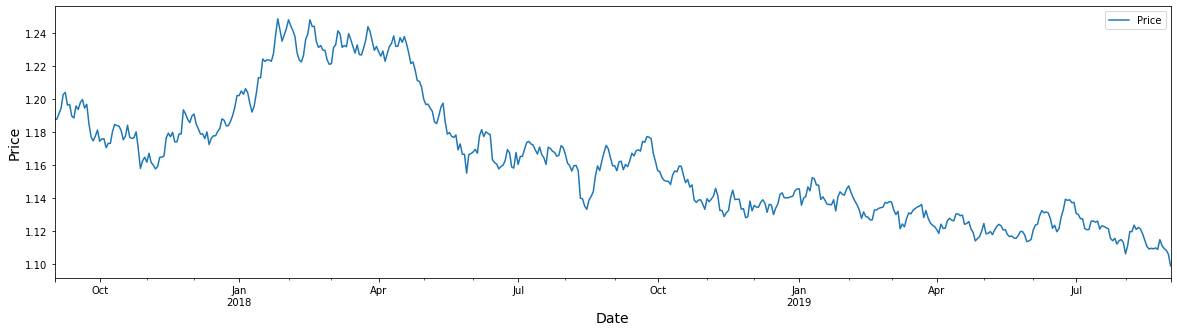

In [10]:
# Cleaning the input by replacing missing values with the previous value.
clean_input= Input.fillna(method='ffill')
DATA = clean_input
# Renaming the price column from '0' to 'Price.
DATA.rename( columns={0 :'Price'}, inplace=True )

# Plotting the data.
DATA.plot()
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price',fontsize=14)

In [11]:
# We'll split training and test data as 80-20, respectively.
# Getting the number of rows to train the model on. 
train_size= int(len(DATA)*0.8)
test_size= len(DATA) - train_size
# Splitting train and test data then printing the size (rows) of each.
train, test = DATA.iloc[0:train_size], DATA.iloc[train_size:len(DATA)]
print(len(train),len(test))
        

416 105


In [12]:
# Function:create_dataset.
# Converts data into numpy arrays.
def create_dataset(X,y,time_steps=1):
    Xs, ys= [],[]
    for i in range(len(X)-time_steps):
        v= X.iloc[i:(i+time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 1

# Split data into X_train and y_train datasets.
# (train.Price and test.Price extracts the data from the train and test dataframe).
X_train, y_train = create_dataset(train, train.Price, time_steps)

# Splitting test data into X_test and y_test datasets.
X_test, y_test = create_dataset(test, test.Price, time_steps)
print(X_train.shape, y_train.shape)

(415, 1, 1) (415,)


In [13]:
# Defining the LSTM network architecture.
model=keras.Sequential( )
model.add(keras.layers.LSTM(128,input_shape=(X_train.shape[1],X_train.shape[2])))

model.add(keras.layers.Dense(1))
# Compile the model.
model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(0.001))

# Train the model (we use 250 epochs).
history= model.fit(X_train, y_train, epochs=250, batch_size=16,
                  validation_split= 0.1,verbose=1,shuffle=False)


Epoch 1/250
24/24 [==============================] - 3s 27ms/step - loss: 1.2274 - val_loss: 0.7049
Epoch 2/250
24/24 [==============================] - 0s 4ms/step - loss: 0.6658 - val_loss: 0.2713
Epoch 3/250
24/24 [==============================] - 0s 5ms/step - loss: 0.2308 - val_loss: 0.0342
Epoch 4/250
24/24 [==============================] - 0s 5ms/step - loss: 0.0252 - val_loss: 3.0219e-04
Epoch 5/250
24/24 [==============================] - 0s 5ms/step - loss: 2.3689e-04 - val_loss: 0.0011
Epoch 6/250
24/24 [==============================] - 0s 5ms/step - loss: 1.6789e-04 - val_loss: 2.5993e-04
Epoch 7/250
24/24 [==============================] - 0s 5ms/step - loss: 1.7065e-04 - val_loss: 2.5636e-04
Epoch 8/250
24/24 [==============================] - 0s 6ms/step - loss: 1.5519e-04 - val_loss: 3.0469e-04
Epoch 9/250
24/24 [==============================] - 0s 6ms/step - loss: 1.4508e-04 - val_loss: 2.9424e-04
Epoch 10/250
24/24 [==============================] - 0s 5ms/step - 

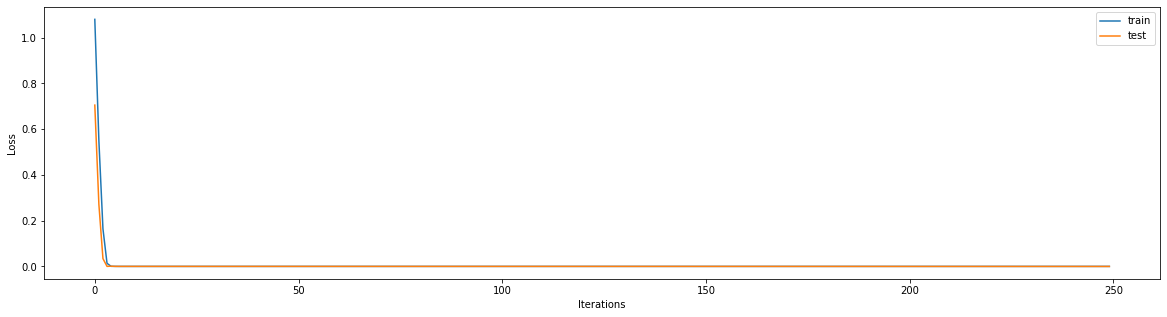

In [14]:
plt.plot(history.history['loss'], label= 'train')
plt.plot(history.history['val_loss'], label= 'test')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend();

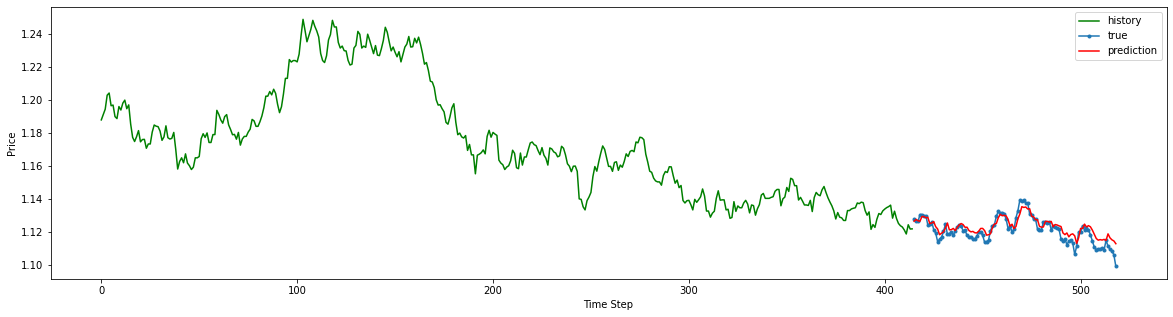

In [15]:
# Get the models predicted price values.
y_pred=model.predict(X_test)

# Plot the predictions along with the true outcomes
plt.plot(np.arange(0,len(y_train)), y_train, 'g',label="history")
plt.plot(np.arange(len(y_train), len(y_train)+ len(y_test)), y_test, marker='.',label="true")
plt.plot(np.arange(len(y_train), len(y_train)+ len(y_test)), y_pred,  'r', label="prediction")

plt.ylabel('Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [18]:
# Showing the actual and predicted prices.
actual= pd.DataFrame(y_test,columns= ['True'])
actual.insert(1, "Predicted", y_pred, True)
from math import sqrt

# Calculating the RMSE.
rmse = sqrt(mean((y_pred-y_test)**2))
print(f'The root mean-squared-error is: {rmse}')

The root mean-squared-error is: 0.009414674596653058
